In [1]:
#Installers
#---conda install -c conda-forge shap
#To install CatBoost from the conda-forge channel:

#Add conda-forge to your channels:
#---conda config --add channels conda-forge
#Install CatBoost:
#---conda install catboost
#Install visualization tools:
#Install the ipywidgets Python package (version 7.x or higher is required):

#---pip install ipywidgets
#Turn on the widgets extension:

#---jupyter nbextension enable --py widgetsnbextension

import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
from catboost import *
import matplotlib.pyplot as plt
import shap
from time import time



## Analysis de modelo Catboost Proyecto Final

## Jason Solano

## Percy Herrera

A raiz del analysis previo de los otros modelos decidimos utilizar Catboost para el analysis de nuestro set de datos dado que nos fue recomendado por su utilidad para la clasificacion de set de datos con grandes cantidades de datos categoricos.
Ademas de su interaccion con varias herramientas de visualizacion

## Prueba de Catboost

### Carga de datos

In [2]:
df1 = pd.read_csv('proyectoF1T.csv')
df2 = pd.read_csv('proyectoF2F.csv')


df1 = df1.append(df2)
df2 = None    
print(df1.shape)

(6095, 31)


Eliminacion de columnas con base en analysis anterior durante el proceso de ADA por su gran cantidad de nulos y poca distribucion.

In [3]:
dfp = df1.drop(columns=['collections_category','amount_financed','last_payment_amount','black_listed','military_applicant','id','merchant_id'])
dfp.columns.shape

(24,)

In [4]:
dfp.isna().mean().round(4) 

approval_amount                0.0000
recommendation                 0.0000
redeem_ts                      0.5742
contacted                      0.0000
email_contacted_ts             0.0786
sms_contacted_ts               0.3993
birth_dt                       0.0000
state                          0.0000
city                           0.0003
zip_code                       0.0000
rent_or_own                    0.0000
months_at_current_residence    0.0000
years_at_current_residence     0.0000
direct_deposit                 0.0028
language_preference            0.0000
payment_frequency              0.0000
scheduled_payment_amt          0.0000
past_due_amt                   0.0000
account_payment_method         0.0000
days_past_due                  0.0000
number_of_payments             0.0000
data_correction                0.0000
source                         0.0000
initial_decision               0.0000
dtype: float64

## Conversion de datos nulos
Como ya explicamos en la etapa de ADA esta conversion es necesaria, dado que estas columnas almacenan el datos de la fecha en que sucedio cada accion, de contacto por correo o sms y la fecha de canje de la oferta

In [5]:
dfp.loc[~dfp.email_contacted_ts.isnull(),"email_contacted_ts"]=True 
dfp.loc[~dfp.sms_contacted_ts.isnull(),"sms_contacted_ts"]=True 
dfp.loc[~dfp.direct_deposit.isnull(),"direct_deposit"]=True 
dfp.loc[~dfp.redeem_ts.isnull(),"redeem_ts"]=True 
dfp["email_contacted_ts"].fillna(False, inplace = True) 
dfp["sms_contacted_ts"].fillna(False, inplace = True)
dfp["direct_deposit"].fillna(False, inplace = True)
dfp["redeem_ts"].fillna(False, inplace = True) 
dfp.head()

,approval_amount,recommendation,redeem_ts,contacted,email_contacted_ts,sms_contacted_ts,birth_dt,state,city,zip_code,...,language_preference,payment_frequency,scheduled_payment_amt,past_due_amt,account_payment_method,days_past_due,number_of_payments,data_correction,source,initial_decision
0,250.0,APPROVE,True,False,False,True,1988-05-21,CO,Aurora,80012,...,EN,WEEKLY,18.84,0.0,MANUAL,0,52,False,MERCHANT,APPROVED
1,80.0,APPROVE,True,False,True,False,1998-01-13,TX,Weatherford,76086,...,EN,BI_WEEKLY,32.88,0.0,MANUAL,0,26,False,INTERNET,APPROVED
2,956.0,APPROVE,True,False,True,True,1975-12-09,WA,Othello,99344,...,ES,MONTHLY,423.50,0.0,MANUAL,0,12,False,MERCHANT,APPROVED
3,9.0,APPROVE,True,False,False,True,1985-09-09,CA,Imperial,92251,...,EN,BI_WEEKLY,18.15,0.0,MANUAL,0,26,False,MERCHANT,APPROVED
4,250.0,APPROVE,True,False,True,True,1980-11-23,OH,Cleveland,44105,...,EN,BI_WEEKLY,87.73,0.0,MANUAL,0,26,False,MERCHANT,APPROVED


##### Conversion de la columna de fecha de nacimiento por edad que resulta mas significativo y simplifica su analizis

In [6]:
now = pd.Timestamp('now')
dfp['birth_dt'] = pd.to_datetime(dfp['birth_dt'])   
dfp['age'] = (now - dfp['birth_dt']).astype('<m8[Y]') 
dfp = dfp.drop(columns=['birth_dt'])
dfp.isna().mean().round(4) 


approval_amount                0.0000
recommendation                 0.0000
redeem_ts                      0.0000
contacted                      0.0000
email_contacted_ts             0.0000
sms_contacted_ts               0.0000
state                          0.0000
city                           0.0003
zip_code                       0.0000
rent_or_own                    0.0000
months_at_current_residence    0.0000
years_at_current_residence     0.0000
direct_deposit                 0.0000
language_preference            0.0000
payment_frequency              0.0000
scheduled_payment_amt          0.0000
past_due_amt                   0.0000
account_payment_method         0.0000
days_past_due                  0.0000
number_of_payments             0.0000
data_correction                0.0000
source                         0.0000
initial_decision               0.0000
age                            0.0000
dtype: float64

##### A este punto el set de datos esta casi listo, procedemos a eliminar los pocos datos nulos que se mantenien en nuestro set de datos

In [7]:
dfp = dfp.dropna()
dfp.shape

(6093, 24)

In [8]:
dfp.isna().mean().round(4) 

approval_amount                0.0
recommendation                 0.0
redeem_ts                      0.0
contacted                      0.0
email_contacted_ts             0.0
sms_contacted_ts               0.0
state                          0.0
city                           0.0
zip_code                       0.0
rent_or_own                    0.0
months_at_current_residence    0.0
years_at_current_residence     0.0
direct_deposit                 0.0
language_preference            0.0
payment_frequency              0.0
scheduled_payment_amt          0.0
past_due_amt                   0.0
account_payment_method         0.0
days_past_due                  0.0
number_of_payments             0.0
data_correction                0.0
source                         0.0
initial_decision               0.0
age                            0.0
dtype: float64

##### Eliminacion de nulos

Como se puede evidenciar en el resultado anterior nuestro set de datos esta libre de nulos y casi listo para ser utilizado para entrenamiento del modelo Catboost

##### Conversion de Boleanos a numerico

Procedemos a cambiar estos valores por datos numericos para simplificar nuestro entrenamiento del modelo.

In [9]:
dfp['contacted']=dfp['contacted'].replace({False: 0, True :1})
dfp['email_contacted_ts']=dfp['email_contacted_ts'].replace({False: 0, True :1})
dfp['sms_contacted_ts']=dfp['sms_contacted_ts'].replace({False: 0, True :1})
dfp['rent_or_own']=dfp['rent_or_own'].replace({'RENT': 0, 'OWN' :1})
dfp['direct_deposit']=dfp['direct_deposit'].replace({False: 0, True :1})
dfp['language_preference']=dfp['language_preference'].replace({'EN': 0, 'ES' :1})
dfp['redeem_ts']=dfp['redeem_ts'].replace({False: 0, True :1})
dfp['data_correction']=dfp['data_correction'].replace({False: 0, True :1})

ind = 0
for i in dfp.columns:
    print(i + ' index # ', ind)
    ind += 1
    print(dfp[i].head())

dfp.head()

approval_amount index #  0
0    250.0
1     80.0
2    956.0
3      9.0
4    250.0
Name: approval_amount, dtype: float64
recommendation index #  1
0    APPROVE
1    APPROVE
2    APPROVE
3    APPROVE
4    APPROVE
Name: recommendation, dtype: object
redeem_ts index #  2
0    1
1    1
2    1
3    1
4    1
Name: redeem_ts, dtype: int64
contacted index #  3
0    0
1    0
2    0
3    0
4    0
Name: contacted, dtype: int64
email_contacted_ts index #  4
0    0
1    1
2    1
3    0
4    1
Name: email_contacted_ts, dtype: int64
sms_contacted_ts index #  5
0    1
1    0
2    1
3    1
4    1
Name: sms_contacted_ts, dtype: int64
state index #  6
0    CO
1    TX
2    WA
3    CA
4    OH
Name: state, dtype: object
city index #  7
0         Aurora
1    Weatherford
2        Othello
3       Imperial
4      Cleveland
Name: city, dtype: object
zip_code index #  8
0    80012
1    76086
2    99344
3    92251
4    44105
Name: zip_code, dtype: int64
rent_or_own index #  9
0    0
1    0
2    0
3    0
4    0
Name

,approval_amount,recommendation,redeem_ts,contacted,email_contacted_ts,sms_contacted_ts,state,city,zip_code,rent_or_own,...,payment_frequency,scheduled_payment_amt,past_due_amt,account_payment_method,days_past_due,number_of_payments,data_correction,source,initial_decision,age
0,250.0,APPROVE,1,0,0,1,CO,Aurora,80012,0,...,WEEKLY,18.84,0.0,MANUAL,0,52,0,MERCHANT,APPROVED,31.0
1,80.0,APPROVE,1,0,1,0,TX,Weatherford,76086,0,...,BI_WEEKLY,32.88,0.0,MANUAL,0,26,0,INTERNET,APPROVED,21.0
2,956.0,APPROVE,1,0,1,1,WA,Othello,99344,0,...,MONTHLY,423.50,0.0,MANUAL,0,12,0,MERCHANT,APPROVED,43.0
3,9.0,APPROVE,1,0,0,1,CA,Imperial,92251,0,...,BI_WEEKLY,18.15,0.0,MANUAL,0,26,0,MERCHANT,APPROVED,34.0
4,250.0,APPROVE,1,0,1,1,OH,Cleveland,44105,0,...,BI_WEEKLY,87.73,0.0,MANUAL,0,26,0,MERCHANT,APPROVED,38.0


### Balanceo de datos

Como vimos en preprocesamiento de nuestros datos, esta es un paso muy importante en la depuracion de datos para el entrenamiento de nuestro modelo.

In [10]:
redeem = dfp[(dfp['redeem_ts'] == 1)]
noRedeem = dfp[(dfp['redeem_ts'] == 0)]

In [11]:
redeem.shape

(2595, 24)

In [12]:
noRedeem.shape

(3498, 24)

En este paso nos aseguramos que nuestros datos contengan una cantidad balanceada de datos por el valor de clasificacion.

In [13]:
dfBalanceado = pd.concat([redeem,noRedeem.sample(redeem.shape[0])])
dfBalanceado.shape

(5190, 24)

##### Separacion del set de datos

Dividimos nuestros datos en features que seria el equivalente a nuestros datos X y labels que serian el equivalente a nuestros datos Y, queremos que nuestro set de testing sea de un tamaño de 35% con un random state de 13.

In [14]:
labels = dfBalanceado['redeem_ts']
features = dfBalanceado.drop(columns=['redeem_ts'])

X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.35,random_state=13)

## Feature importance

Las siguientes funciones las utilizaremos mas adelante para poder visualizar la importancia de las columnas de una forma clara y detallada, utilizaremos varios metodos para revisar la importancia de nuestras columnas y determinar cuales podemos eliminar.

In [15]:

def log_loss(m, X, y): 
    return metrics.log_loss(y,m.predict_proba(X)[:,1])
    
def permutation_importances(model, X, y, metric):
    baseline = metric(model, X, y)
    imp = []
    for col in X.columns:
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        m = metric(model, X, y)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)

In [16]:
def baseline_importance(model, X, y, X_test, y_test, metric):
    
    model = CatBoostClassifier(one_hot_max_size = 10, iterations = 500)
    model.fit(X, y, cat_features = categorical_features_indices, verbose = False)
    baseline = metric(model, X_test, y_test)
    
    imp = []
    for col in X.columns:
        
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        
        model.fit(X, y, cat_features = categorical_features_indices, verbose = False)
        m = metric(model, X_test, y_test)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)


###### Analizamos la cantidad de diferentes valores por columna

In [17]:
for col in X_train.columns:
    print(col, X_train[col].nunique())
    
X_train.head()    

approval_amount 1200
recommendation 2
contacted 2
email_contacted_ts 2
sms_contacted_ts 2
state 46
city 1197
zip_code 2128
rent_or_own 2
months_at_current_residence 13
years_at_current_residence 29
direct_deposit 2
language_preference 2
payment_frequency 5
scheduled_payment_amt 3005
past_due_amt 297
account_payment_method 3
days_past_due 105
number_of_payments 4
data_correction 2
source 7
initial_decision 3
age 65


,approval_amount,recommendation,contacted,email_contacted_ts,sms_contacted_ts,state,city,zip_code,rent_or_own,months_at_current_residence,...,payment_frequency,scheduled_payment_amt,past_due_amt,account_payment_method,days_past_due,number_of_payments,data_correction,source,initial_decision,age
2889,505.0,APPROVE,0,1,1,AZ,El Mirage,85335,1,2,...,BI_WEEKLY,67.53,0.0,MANUAL,0,26,0,MERCHANT,APPROVED,39.0
1365,363.0,APPROVE,0,1,1,CA,San Francisco,94112,1,0,...,BI_WEEKLY,44.55,0.0,MANUAL,0,26,0,MERCHANT,APPROVED,34.0
2125,1188.0,APPROVE,0,1,1,TX,Lubbock,79415,0,1,...,MONTHLY,420.43,0.0,CARD,0,52,0,MERCHANT,APPROVED,29.0
3320,671.0,APPROVE,0,1,0,FL,Miami,33157,0,0,...,WEEKLY,44.29,0.0,MANUAL,0,52,0,MERCHANT,APPROVED,27.0
9,273.0,APPROVE,0,1,1,PA,Allentown,18102,0,0,...,MONTHLY_WEEK,85.30,0.0,MANUAL,0,12,0,SNAP_FINANCE_COM,APPROVED,52.0


En el siguiente paso definimos un arreglo con los indices de nuestras columnas categoricas, un parametro 
que es necesario para el entrenamiento del modelo Catboost, tambien definimos un arreglo con las diferentes iteraciones
que queremos probar para darnos una idea de cual seria un numero bueno de iteraciones para el entrenamiento.

En este ciclo entrenamos por los diferentes valores del parametro iteraciones y utilizamos la funcion anterior "Log_loss"
para construir un arreglo de estos valores para luego graficar los resultados.  

In [19]:
categorical_features_indices = [1,5,6,8,12,13,16,20,21]

iteration = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800,1000,1600,1800,2000]
loss = []
for i in iteration:
    model = CatBoostClassifier(one_hot_max_size = 10, iterations = i)
    model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = False
    )
    loss.append((i, log_loss(model, X_test, y_test), log_loss(model, X_train, y_train)))
    print(i)

50
100
150


KeyboardInterrupt: 

<function matplotlib.pyplot.show(*args, **kw)>

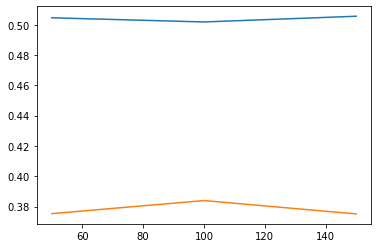

In [20]:
plt.plot([i[0] for i in loss],[i[1] for i in loss]) 
plt.plot([i[0] for i in loss],[i[2] for i in loss]) 
plt.show

De forma manual comprobamos la metrica "log_loss" con nuestro set de datos de validacion, y al parecer cerca de las 500 iteraciones se encuentra el mejor punto y luego se estabiliza sin muestras de mejora. Procederemos a entrenar nuestro modelo con 500 iteraciones y realizar los analysis siguientes con las metricas resultantes de este modelo.

In [21]:
model = CatBoostClassifier(one_hot_max_size = 10, iterations = 700)
model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = False
)

## Analysis de importancia de variables con Shap

Haciendo uso de la integracion del modelo Catboost con el kernel de Shap obtenemos la siguiente visualizacion de la importancia de nuestras variables y asi tomar como punto base para revisar cuales variables son candidatas de eliminacion

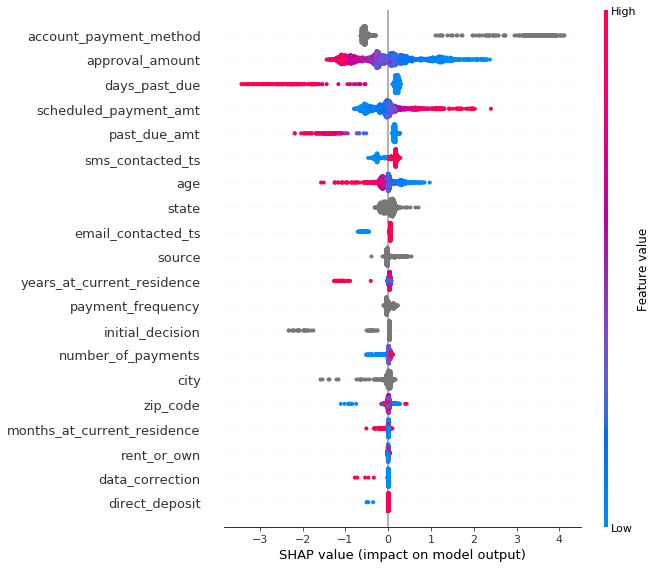

In [22]:
import time
shap.initjs()


start_time = time.time()
shap_values = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, X_test) 
elapsed = time.time() - start_time

In [23]:
elapsed


1.5746040344238281

In [24]:
import timeit
timeit.default_timer()


204219.754440985

La siguiente funcion definimos varios metodos que nos permite visualizar la importancia de las variables desde diferentes calculos y comparar entre si cuales variables son descartables y cuales tienen mucha relevancia desde los diferentes metodos de calculo.

In [25]:
def get_feature_imp_plot(method):
    
    if method == "Permutation":
        fi =  permutation_importances(model, X_test, y_test, log_loss)
    
    elif method == "Baseline":
        fi = baseline_importance(model, X_train, y_train, X_test, y_test, log_loss)
    
    elif method == "ShapeValues":
        shap_values = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
        shap_values = shap_values[:,:-1]
        shap.summary_plot(shap_values, X_test) 
        
    else:
        fi = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

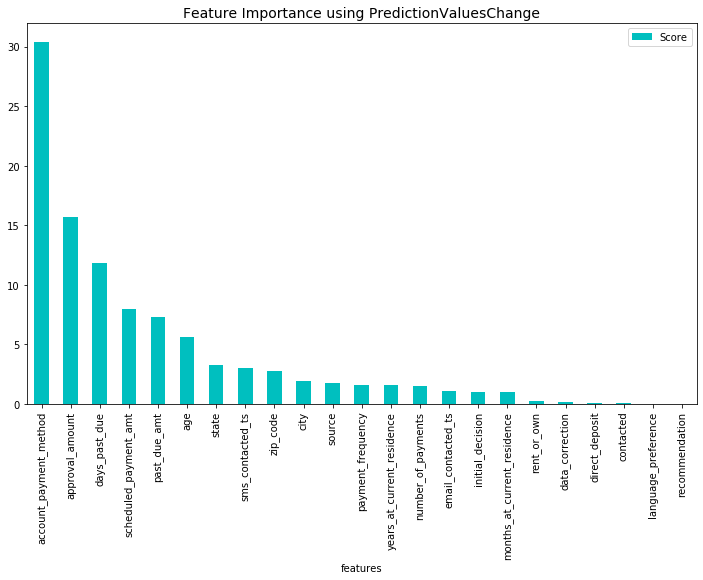

CPU times: user 239 ms, sys: 10.3 ms, total: 250 ms
Wall time: 269 ms


In [26]:
%time get_feature_imp_plot(method="PredictionValuesChange")


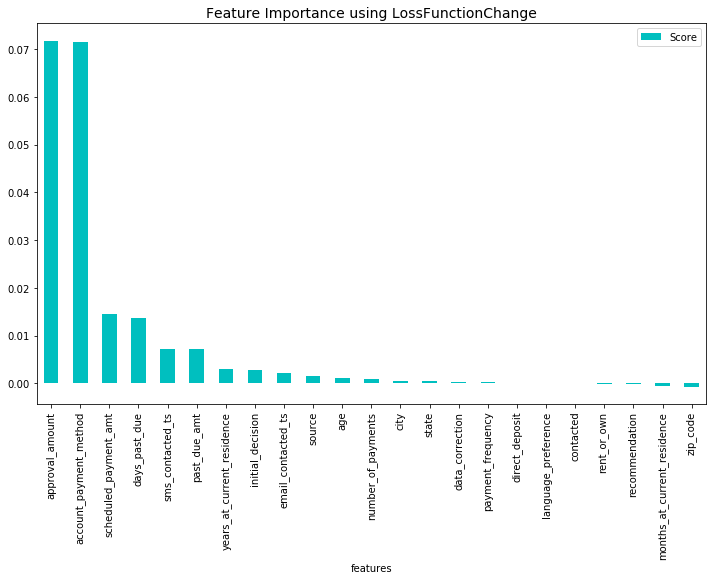

CPU times: user 1.77 s, sys: 23.1 ms, total: 1.8 s
Wall time: 716 ms


In [27]:
%time get_feature_imp_plot(method="LossFunctionChange")


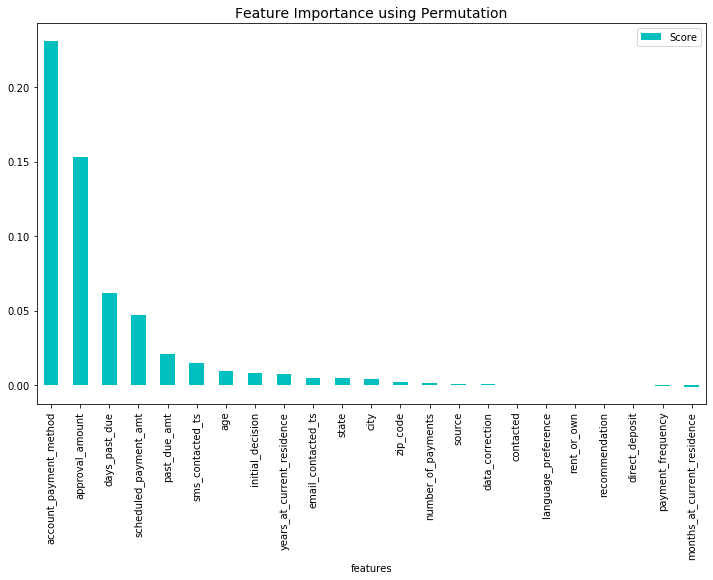

CPU times: user 592 ms, sys: 16.4 ms, total: 609 ms
Wall time: 474 ms


In [28]:
%time get_feature_imp_plot(method="Permutation")


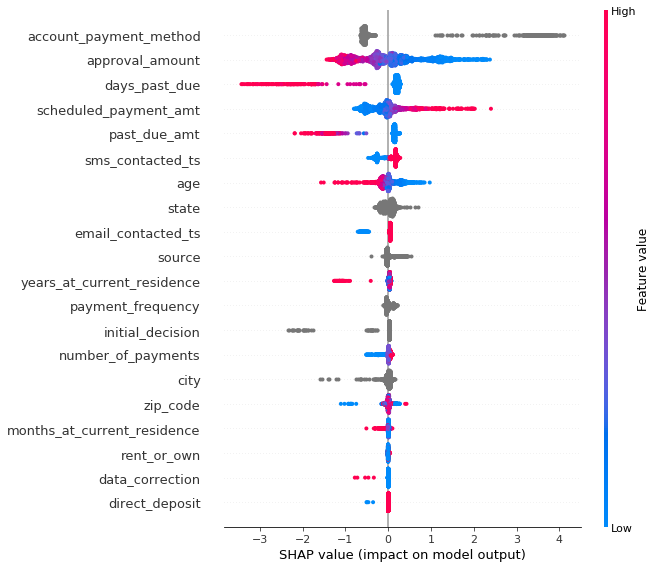

CPU times: user 3.05 s, sys: 520 ms, total: 3.57 s
Wall time: 1.39 s


In [29]:
%time get_feature_imp_plot(method="ShapeValues")


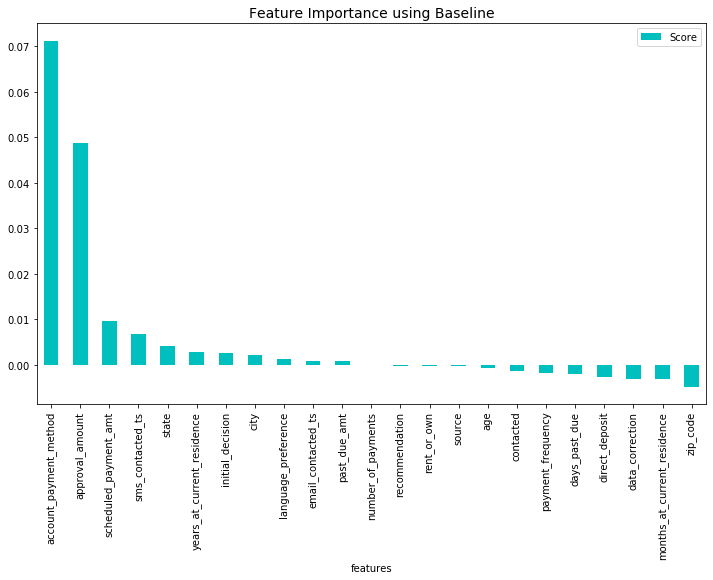

CPU times: user 10min 30s, sys: 2min 44s, total: 13min 15s
Wall time: 3min 47s


In [30]:
%time get_feature_imp_plot(method="Baseline")


## importancia de Interacion de Variables 

El siguiente analysis muestra cual es la interaccion entre variables y su puntaje de interaccion, un analisis muy interesante que nos muestra de forma visual la importancia entre estas interaciones y da gran ayuda para la toma de decisiones en cuanto a variables para eliminar.

In [31]:
fi = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type="Interaction")

In [32]:
fi[:5]

array([[ 0.        , 14.        ,  5.08381943],
       [ 0.        ,  5.        ,  4.45417916],
       [ 0.        , 22.        ,  3.29971933],
       [14.        , 22.        ,  3.22410931],
       [ 0.        , 17.        ,  3.03227824]])

In [33]:
fi_new = []
for k,item in enumerate(fi):  
    first = X_test.dtypes.index[fi[k][0]]
    second = X_test.dtypes.index[fi[k][1]]
    if first != second:
        fi_new.append([first + "/" + second, fi[k][2]])

In [34]:
fi_new[:5]

[['approval_amount/scheduled_payment_amt', 5.083819433907874],
 ['approval_amount/state', 4.454179163163649],
 ['approval_amount/age', 3.299719332923121],
 ['scheduled_payment_amt/age', 3.2241093093073045],
 ['approval_amount/days_past_due', 3.0322782377645363]]

In [35]:
feature_score = pd.DataFrame(fi_new,columns=['Feature-Pair','Score'])

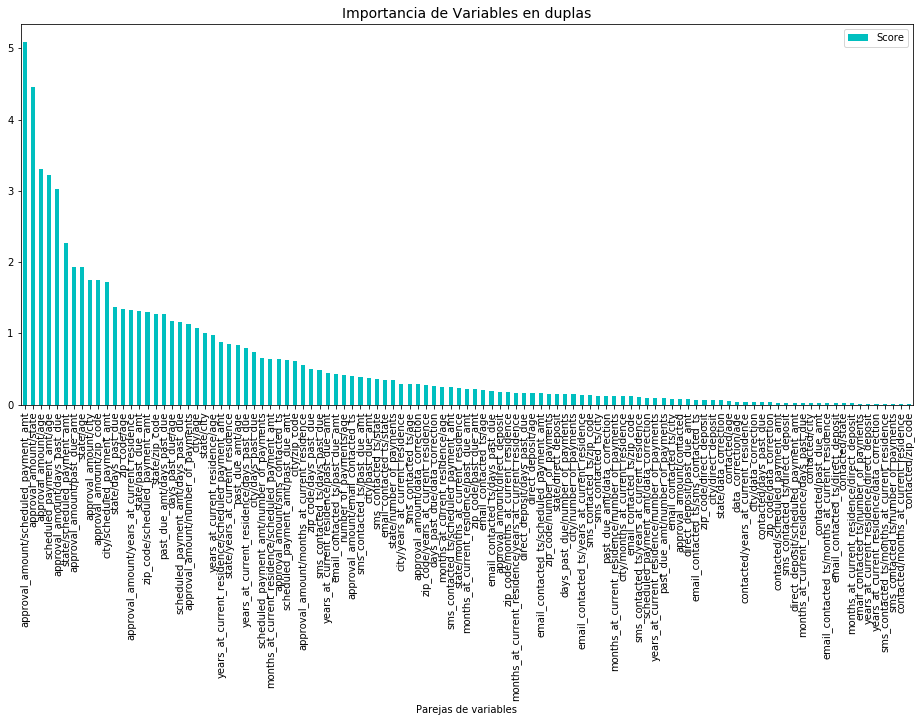

In [36]:
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (16,7)
ax = feature_score.plot('Feature-Pair', 'Score', kind='bar', color='c')
ax.set_title("Importancia de Variables en duplas", fontsize = 14)
ax.set_xlabel("Parejas de variables")
plt.show()

#### Analysis estadistico de las variables significativas

Mostramos visualizaciones con la estadisticas de las variables mas significativas segun los estudios anteriores.

In [37]:
feature = 'account_payment_method'
res = model.calc_feature_statistics(X_train, y_train, feature, plot=True)

ImportError: No module named 'plotly'

In [38]:
feature = 'approval_amount'
res = model.calc_feature_statistics(X_train, y_train, feature, plot=True)

In [39]:
feature = 'days_past_due'
res = model.calc_feature_statistics(X_train, y_train, feature, plot=True)

#### Variables a elimiar

Despues de analizado el resultado de los graficos anteriores decidimos eliminar la siguientes variables:

data_correction - rent_or_own - language_preference - contacted - direct_deposit - recommendation

Esto para proceder a entrenar nuestro modelo con el set de datos depurado y tratando de eliminar al maximo el ruido que pudieran ocasionar estas variables.

Volvemos a dividir nuestros set de datos para entrenamiento y validacion.

In [40]:
features = features.drop(columns=['data_correction','rent_or_own','language_preference','contacted','direct_deposit','recommendation'])

X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.35,random_state=13)


In [41]:
features.head()

,approval_amount,email_contacted_ts,sms_contacted_ts,state,city,zip_code,months_at_current_residence,years_at_current_residence,payment_frequency,scheduled_payment_amt,past_due_amt,account_payment_method,days_past_due,number_of_payments,source,initial_decision,age
0,250.0,0,1,CO,Aurora,80012,1,2,WEEKLY,18.84,0.0,MANUAL,0,52,MERCHANT,APPROVED,31.0
1,80.0,1,0,TX,Weatherford,76086,0,1,BI_WEEKLY,32.88,0.0,MANUAL,0,26,INTERNET,APPROVED,21.0
2,956.0,1,1,WA,Othello,99344,0,1,MONTHLY,423.50,0.0,MANUAL,0,12,MERCHANT,APPROVED,43.0
3,9.0,0,1,CA,Imperial,92251,11,0,BI_WEEKLY,18.15,0.0,MANUAL,0,26,MERCHANT,APPROVED,34.0
4,250.0,1,1,OH,Cleveland,44105,0,6,BI_WEEKLY,87.73,0.0,MANUAL,0,26,MERCHANT,APPROVED,38.0


Volvemos a definir el arreglo de indices de nuestras columnas categoricas, dado que es un parametro fundamental para el entrenamiento de nuestro modelo con Catboost

In [42]:
categorical_features_indices = [3,4,8,11,14,15]

### Entrenamiento y test

Aprovechando las herramientas que facilita Catboost, hacemos uso del parametro plot para que nos muestre dinamicamente el entrenamiento y como se va comportando la tendencia del error tanto para entrenamiento como para el set de validacion.

In [43]:
model2 = CatBoostClassifier(one_hot_max_size = 10, iterations = 2000)
model2.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    eval_set=(X_test, y_test),
    verbose = False,plot =True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

El grafico del entrenamiento anterior nos muestra el mejor punto a la altura de la iteracion 216 con un porcentaje de error del 
42% para entrenamiento y 48% para testing

In [61]:
model3 = CatBoostClassifier(one_hot_max_size = 10, iterations = 15000,loss_function='MultiClass')
model3.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    eval_set=(X_test, y_test),
    verbose = False,plot =True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

En el entrenamiento anterior utilizamos una cantidad considerable de iteraciones con un valor de 15 000 y especificando como funcion de perdida 'Multiclass', los resultados anteriores nos muestran el mejor punto en la iteracion 749 con un porcentaje de error de 41% en entrenamiento y 48% en testing. Usando esta amplia cantidad de iteraciones confirmamos que el porcentaje de error tiende a subir en los valores de testing y a bajar para los valores de training por lo que estamos en presencia de un claro caso de overfiting.

In [62]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=3000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    loss_function='MultiClass',
    leaf_estimation_method='Newton'
)
tunned_model.fit(
    X_train, y_train,
    verbose=False,
    cat_features = categorical_features_indices,
    eval_set=(X_test, y_test),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Quisimos hacer una prueba con varios hyperparametros y haciendo un tunning parecido a un ejemplo visto en un analysis didactico del modelo Catboost y confirmamos que se comporta muy parecido, por lo que nos parece confiable los resultados de los entrenamientos con sus valores default, a esta altura del analysis con esta prueba no logramos mejorar el porcentaje de error de testing en 48% y mientras que el training nos muestra un porcentaje bajo en 29%.